# Multi Salmo microbetag networks analysis

## Functions

In [1]:
def count_edge_types(cx2):
    """
    Gets a .cx2 microbetag annotated network to retun statistics on its edges 
    
    """
    edge_id_sign = {}
    edge_id_2_number_of_complements = {}
    edge_types = {
        "taxon_to_taxon": {"edges": [], "counts": 0},  # done
        "taxon_to_metabo": {"edges": [], "counts": 0},
        "taxon_to_env": {"edges": [], "counts": 0}, 
        "metabo_to_metabo": {"edges": [], "counts": 0}, # done
        "env_to_env": {"edges": [], "counts": 0},       # done
        "metabo_to_env": {"edges": [], "counts": 0}
    }

    source_target_edge_ids = {}
    taxa_pairs_with_positive_weight = []

    for _, edge in cx2.get_edges().items():
        
        edge_id = edge["id"]

        if "completes/competes with" == edge["v"]["interaction type"]:
            for k in edge["v"]:
                # NOTE For PATHWAY COMPLEMENTS
                # if "compl::" in k:
                #     edge_id_2_number_of_complements[edge_id] = len(edge["v"][k])
                if k.startswith("seedCompl::"):
                    edge_id_2_number_of_complements[edge_id] = len(edge["v"][k])

        else:
            if 'microbetag::weight' in edge["v"]:
                if edge["v"]["microbetag::weight"] > 0:
                    edge_id_sign[edge_id] = 1
                    taxa_pairs_with_positive_weight.append((edge["s"], edge["t"]))
                else:
                    edge_id_sign[edge_id] = -1

        source_target_edge_ids[(edge["s"], edge["t"])] = edge_id

        source, target = edge["s"], edge["t"]
        
        node_source = cx2.get_nodes()[source]
        source_name = node_source["v"]["name"]
        
        node_target = cx2.get_nodes()[target]
        target_name = node_target["v"]["name"]
        
        if source_name not in env_set | metabolites_set and target_name not in env_set | metabolites_set:
            edge_types["taxon_to_taxon"]["counts"] += 1
            edge_types["taxon_to_taxon"]["edges"].append(edge_id)

        elif source_name in env_set and target_name in env_set:
            edge_types["env_to_env"]["counts"] += 1
            edge_types["env_to_env"]["edges"].append(edge_id)

        elif source_name in metabolites_set and target_name in metabolites_set:
            edge_types["metabo_to_metabo"]["counts"] += 1
            edge_types["metabo_to_metabo"]["edges"].append(edge_id)

        elif {source_name, target_name} <= env_set | metabolites_set and source_name in env_set ^ metabolites_set:
            edge_types["metabo_to_env"]["counts"] += 1
            edge_types["metabo_to_env"]["edges"].append(edge_id)

        elif {source_name, target_name} & env_set and not {source_name, target_name} & metabolites_set:
            edge_types["taxon_to_env"]["counts"] += 1
            edge_types["taxon_to_env"]["edges"].append(edge_id)

        elif {source_name, target_name} & metabolites_set and not {source_name, target_name} & env_set:
            edge_types["taxon_to_metabo"]["counts"] += 1
            edge_types["taxon_to_metabo"]["edges"].append(edge_id)

        else:
            print("PROBLEM:", source_name, target_name)

    return edge_id_2_number_of_complements, edge_types, taxa_pairs_with_positive_weight

In [2]:
def count_number_of_complements(cx2, positive_pairs, edge_id_compl_number):

    number_of_complements_in_positive_associated_taxa = 0

    for _, edge in cx2.get_edges().items():

        s_t = (edge["s"], edge["t"])
        t_s = (edge["t"], edge["s"])
        edge_id = edge["id"]

        if s_t in positive_pairs or t_s in positive_pairs:
            if edge["v"]["interaction type"] == "completes/competes with":
                for k in edge["v"]:
                    if k.startswith("seedCompl::"):
                        number_of_complements_in_positive_associated_taxa += edge_id_compl_number[edge_id]

    return number_of_complements_in_positive_associated_taxa

## Stats

Calculate statistics on the microbetag-annotated networks per day.

In [3]:
import os
import matplotlib.pyplot as plt 

try:
    import ndex2
except ImportError:
    %pip install ndex2

from ndex2.cx2 import RawCX2NetworkFactory

Load the `.cx2` files 

In [4]:
per_day_cx_dir = "/home/luna.kuleuven.be/u0156635/Documents/projects/3D-omics-general/results"
cx_07_filepath = os.path.join(per_day_cx_dir, "microbetag_net_day_7.cx2")
cx_14_filepath = os.path.join(per_day_cx_dir, "microbetag_net_day_14.cx2")
cx_21_filepath = os.path.join(per_day_cx_dir, "microbetag_net_day_21.cx2")
cx_28_filepath = os.path.join(per_day_cx_dir, "microbetag_net_day_28.cx2")
cx_35_filepath = os.path.join(per_day_cx_dir, "microbetag_net_day_35.cx2")

In [5]:
def load_cx2(filepath):
    factory = RawCX2NetworkFactory()
    net = factory.get_cx2network(filepath)
    return net

In [6]:
cx_07 = load_cx2(cx_07_filepath)
cx_14 = load_cx2(cx_14_filepath)
cx_21 = load_cx2(cx_21_filepath)
cx_28 = load_cx2(cx_28_filepath)
cx_35 = load_cx2(cx_35_filepath)

Keep track of the non-sequence nodes.

In [7]:
env_var = ["treatment_TG1", "treatment_TG2", "treatment_TG3", "treatment_TG4", "treatment_TG5", 
           "day", "salmonella", "synbiotic_water", "synbiotic_feed"
]
metabolites = [
"L-Tyrosine", "L-Phenylalanine", "L-Tryptophan", "L-Aspartic Acid", "L-Arginine", "L-Leucine", "L-Glutamic acid", "L-Glutamine", 
"L-Histidine", "L-Lysine", "L-Methionine", "L-Proline", "L-Threonine", "Thiamine", "Adenine", 'Guanosine', "L-Valine" , "L-Alanine", 
"L-Asparagine", "L-Isoleucine", "L-Serine", "Lactic acid", "Sulfoacetic acid"
]
env_set = set(env_var)
metabolites_set = set(metabolites)

Example of how an edge looks like on the `.cx2` format.
```json

// Edge example
    {'id': 245,
    's': 83,
    't': 2,
    'v': {'interaction type': 'cooccurrence',
    'microbetag::weight': 0.9523214101791382,
    'shared name': 'L-Leucine (cooccurss with) L-Isoleucine'}}

```

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day


In [8]:
num_compl_day_07, types_day_07, pos_pairs_07 = count_edge_types(cx_07)
num_compl_day_14, types_day_14, pos_pairs_14 = count_edge_types(cx_14)
num_compl_day_21, types_day_21, pos_pairs_21 = count_edge_types(cx_21)
num_compl_day_28, types_day_28, pos_pairs_28 = count_edge_types(cx_28)
num_compl_day_35, types_day_35, pos_pairs_35 = count_edge_types(cx_35)

In [9]:
days = [7, 14, 21, 28, 35]
taxon_to_metabo_hits = [
    types_day_07["taxon_to_metabo"]["counts"],
    types_day_14["taxon_to_metabo"]["counts"],
    types_day_21["taxon_to_metabo"]["counts"],
    types_day_28["taxon_to_metabo"]["counts"],
    types_day_35["taxon_to_metabo"]["counts"]
]

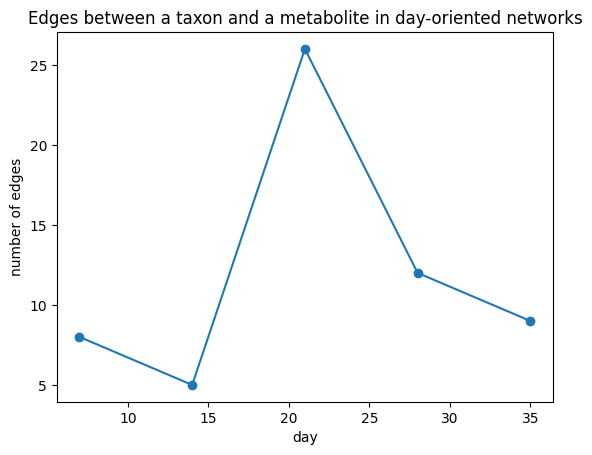

In [23]:
plt.plot(days, taxon_to_metabo_hits, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in day-oriented networks")

# Show the plot
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

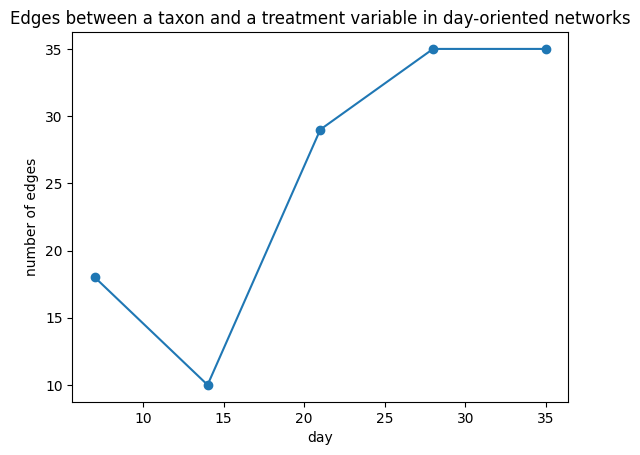

In [22]:
taxon_to_env_hits = [
    types_day_07["taxon_to_env"]["counts"],
    types_day_14["taxon_to_env"]["counts"],
    types_day_21["taxon_to_env"]["counts"],
    types_day_28["taxon_to_env"]["counts"],
    types_day_35["taxon_to_env"]["counts"]
]

plt.plot(days, taxon_to_env_hits, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a treatment variable in day-oriented networks")

# Show the plot
plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [12]:
overall_number_of_seed_compl = [
    sum(num_compl_day_07.values()),
    sum(num_compl_day_14.values()),
    sum(num_compl_day_21.values()),
    sum(num_compl_day_28.values()),
    sum(num_compl_day_35.values())
]

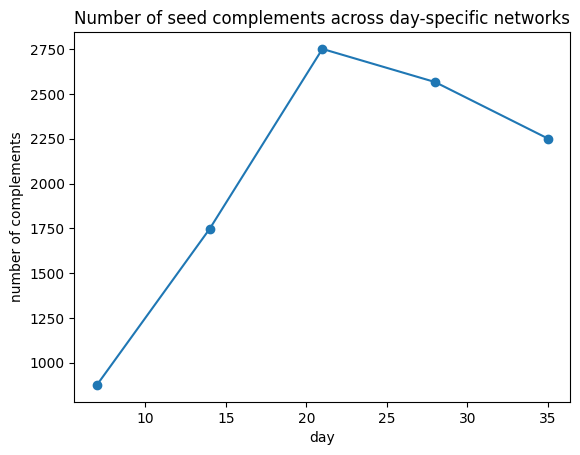

In [21]:
plt.plot(days, overall_number_of_seed_compl, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements across day-specific networks")

# Show the plot
plt.show()


#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [14]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    count_number_of_complements(cx_07, pos_pairs_07, num_compl_day_07),
    count_number_of_complements(cx_14, pos_pairs_14, num_compl_day_14),
    count_number_of_complements(cx_21, pos_pairs_21, num_compl_day_21),
    count_number_of_complements(cx_28, pos_pairs_28, num_compl_day_28),
    count_number_of_complements(cx_35, pos_pairs_35, num_compl_day_35)
]


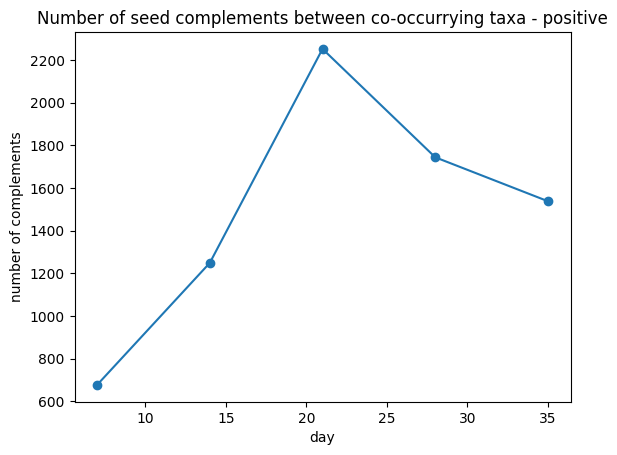

In [19]:
plt.plot(days, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")

# Show the plot
plt.show()


In [16]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[0] / len(pos_pairs_07),
    number_of_seed_compl_per_day_in_positive_associated_taxa[1] / len(pos_pairs_14),
    number_of_seed_compl_per_day_in_positive_associated_taxa[2] / len(pos_pairs_21),
    number_of_seed_compl_per_day_in_positive_associated_taxa[3] / len(pos_pairs_28),
    number_of_seed_compl_per_day_in_positive_associated_taxa[4] / len(pos_pairs_35)
]

mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[0] / len(num_compl_day_07),
    overall_number_of_seed_compl[1] / len(num_compl_day_14),
    overall_number_of_seed_compl[2] / len(num_compl_day_21),
    overall_number_of_seed_compl[3] / len(num_compl_day_28),
    overall_number_of_seed_compl[4] / len(num_compl_day_35)
]

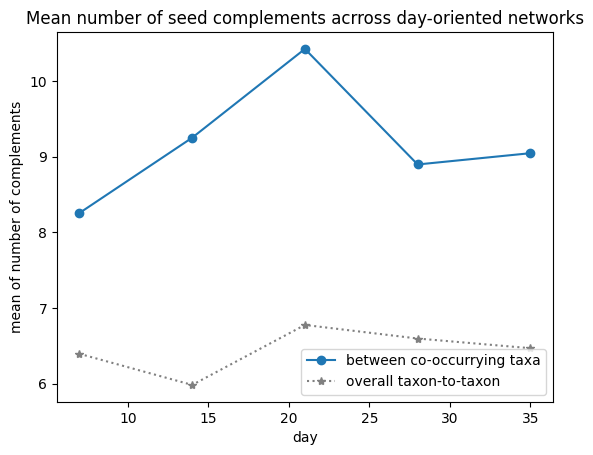

In [18]:
plt.plot(days, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(days, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")

# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements acrross day-oriented networks")

plt.legend()

# Show the plot
plt.show()
